# Install Environment

In [1]:
%pip install jcopdl

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install "jcopdl<2.0"

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install luwiji

Note: you may need to restart the kernel to use updated packages.


In [4]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.10', '1.2.3')

In [5]:
import numpy as np
import matplotlib.pyplot as plts

In [6]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Definisikan parameter
bs = 128
crop_size = 64

# Definisikan transformasi untuk set pelatihan dan pengujian
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

# Muat dataset
dataset = datasets.ImageFolder("/Users/ghanyfitriamaras/Documents/COMPUTER-VISION/PROJECT/dataset-resized")

# Tentukan proporsi pembagian dataset
train_size = int(0.8 * len(dataset))  # 80% untuk set pelatihan
test_size = len(dataset) - train_size  # 20% untuk set pengujian

# Bagi dataset menjadi set pelatihan dan pengujian
train_set, test_set = random_split(dataset, [train_size, test_size])

# Terapkan transformasi pada set pelatihan dan pengujian
train_set.dataset.transform = train_transform
test_set.dataset.transform = test_transform

# Buat DataLoader untuk set pelatihan dan pengujian
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)
testloader = DataLoader(test_set, batch_size=bs, shuffle=False, num_workers=2)

# Verifikasi ukuran set pelatihan dan pengujian
print(f'Train set size: {len(train_set)}')
print(f'Test set size: {len(test_set)}')

Train set size: 2021
Test set size: 506


In [9]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [10]:
train_set[0]

(tensor([[[0.8392, 0.8392, 0.8392,  ..., 0.8235, 0.8235, 0.8196],
          [0.8353, 0.8353, 0.8353,  ..., 0.8196, 0.8157, 0.8157],
          [0.8353, 0.8353, 0.8353,  ..., 0.8157, 0.8157, 0.8118],
          ...,
          [0.7961, 0.8000, 0.8000,  ..., 0.6784, 0.6745, 0.6706],
          [0.7961, 0.8000, 0.8000,  ..., 0.6745, 0.6745, 0.6706],
          [0.7922, 0.7961, 0.7961,  ..., 0.6706, 0.6706, 0.6667]],
 
         [[0.8392, 0.8392, 0.8392,  ..., 0.8235, 0.8235, 0.8196],
          [0.8353, 0.8353, 0.8353,  ..., 0.8196, 0.8157, 0.8157],
          [0.8353, 0.8353, 0.8353,  ..., 0.8157, 0.8157, 0.8118],
          ...,
          [0.7843, 0.7843, 0.7843,  ..., 0.6745, 0.6706, 0.6667],
          [0.7843, 0.7843, 0.7843,  ..., 0.6706, 0.6706, 0.6667],
          [0.7804, 0.7804, 0.7804,  ..., 0.6667, 0.6667, 0.6627]],
 
         [[0.8392, 0.8392, 0.8392,  ..., 0.8235, 0.8235, 0.8196],
          [0.8353, 0.8353, 0.8353,  ..., 0.8196, 0.8157, 0.8157],
          [0.8353, 0.8353, 0.8353,  ...,

In [11]:
label2cat = dataset.classes
label2cat

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Arsitektur dan Config

In [12]:
from jcopdl.layers import conv_block, linear_block

In [13]:
class TrashClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
            
        )
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.3),
            linear_block(256, 6, activation="lsoftmax")
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [14]:
config = set_config({
    "batch_size": bs,
    "crop_size" : crop_size
})

# Training Preparation > MCOC (Model Criterion Optimizer Callback)

In [15]:
model = TrashClassifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, set_config, outdir = "model")

In [16]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [17]:
from tqdm.auto import tqdm #tqdm == progress bar

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    
    cost = correct = 0
    
    for feature, target in tqdm(dataloader, desc = mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()

    cost = cost / len(dataset)
    acc = correct / len(dataset)
    
    return cost, acc

Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch     1
Train_cost  = 1.7387 | Test_cost  = 1.7159 | Train_score = 0.2237 | Test_score = 0.2372 |


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch     2
Train_cost  = 1.7192 | Test_cost  = 1.6938 | Train_score = 0.2187 | Test_score = 0.2372 |
==> EarlyStop patience =  1 | Best test_score: 0.2372


Train:   0%|          | 0/16 [00:03<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch     3
Train_cost  = 1.6426 | Test_cost  = 1.5321 | Train_score = 0.2756 | Test_score = 0.4190 |


Train:   0%|          | 0/16 [00:03<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch     4
Train_cost  = 1.5247 | Test_cost  = 1.4617 | Train_score = 0.3696 | Test_score = 0.4051 |
==> EarlyStop patience =  1 | Best test_score: 0.4190


Train:   0%|          | 0/16 [00:03<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch     5
Train_cost  = 1.4517 | Test_cost  = 1.4177 | Train_score = 0.3825 | Test_score = 0.4170 |
==> EarlyStop patience =  2 | Best test_score: 0.4190


Train:   0%|          | 0/16 [00:03<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch     6
Train_cost  = 1.4099 | Test_cost  = 1.3443 | Train_score = 0.4201 | Test_score = 0.4526 |


Train:   0%|          | 0/16 [00:03<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch     7
Train_cost  = 1.3428 | Test_cost  = 1.3029 | Train_score = 0.4735 | Test_score = 0.4960 |


Train:   0%|          | 0/16 [00:13<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch     8
Train_cost  = 1.2978 | Test_cost  = 1.2871 | Train_score = 0.4933 | Test_score = 0.5099 |


Train:   0%|          | 0/16 [00:03<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch     9
Train_cost  = 1.2844 | Test_cost  = 1.2578 | Train_score = 0.5077 | Test_score = 0.5356 |


Train:   0%|          | 0/16 [00:12<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    10
Train_cost  = 1.2513 | Test_cost  = 1.2707 | Train_score = 0.5166 | Test_score = 0.4960 |
==> EarlyStop patience =  1 | Best test_score: 0.5356


Train:   0%|          | 0/16 [00:12<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    11
Train_cost  = 1.2014 | Test_cost  = 1.2182 | Train_score = 0.5423 | Test_score = 0.5158 |
==> EarlyStop patience =  2 | Best test_score: 0.5356


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch    12
Train_cost  = 1.1935 | Test_cost  = 1.2520 | Train_score = 0.5502 | Test_score = 0.5296 |
==> EarlyStop patience =  3 | Best test_score: 0.5356


Train:   0%|          | 0/16 [00:12<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    13
Train_cost  = 1.1732 | Test_cost  = 1.1793 | Train_score = 0.5591 | Test_score = 0.5534 |


Train:   0%|          | 0/16 [00:13<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    14
Train_cost  = 1.1452 | Test_cost  = 1.1832 | Train_score = 0.5764 | Test_score = 0.5316 |
==> EarlyStop patience =  1 | Best test_score: 0.5534


Train:   0%|          | 0/16 [00:03<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch    15
Train_cost  = 1.0962 | Test_cost  = 1.1519 | Train_score = 0.5878 | Test_score = 0.5613 |


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    16
Train_cost  = 1.0528 | Test_cost  = 1.1290 | Train_score = 0.6076 | Test_score = 0.5771 |


Train:   0%|          | 0/16 [00:12<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    17
Train_cost  = 1.0388 | Test_cost  = 1.1315 | Train_score = 0.6096 | Test_score = 0.5791 |


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    18
Train_cost  = 1.0334 | Test_cost  = 1.0902 | Train_score = 0.6116 | Test_score = 0.6087 |


Train:   0%|          | 0/16 [00:13<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch    19
Train_cost  = 1.0246 | Test_cost  = 1.1819 | Train_score = 0.6190 | Test_score = 0.5553 |
==> EarlyStop patience =  1 | Best test_score: 0.6087


Train:   0%|          | 0/16 [00:13<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch    20
Train_cost  = 0.9900 | Test_cost  = 1.0348 | Train_score = 0.6309 | Test_score = 0.6245 |


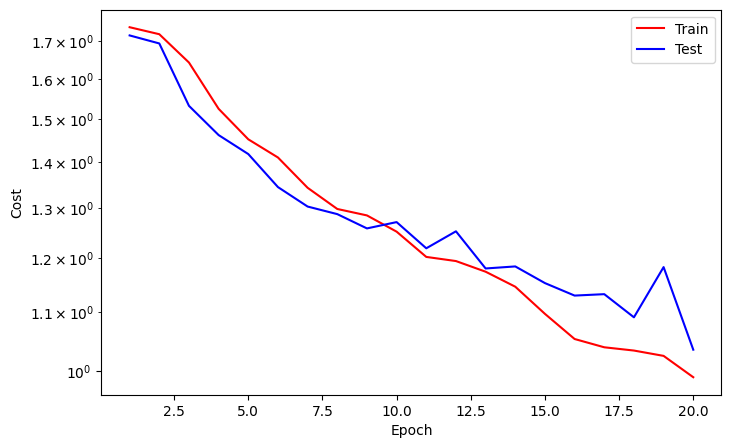

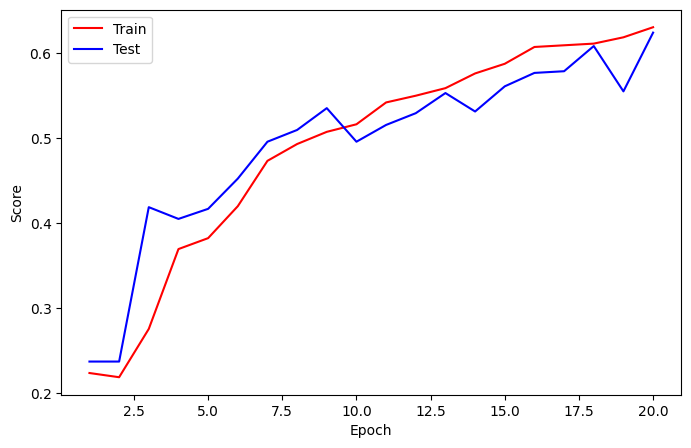

Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    21
Train_cost  = 0.9440 | Test_cost  = 1.0792 | Train_score = 0.6536 | Test_score = 0.6008 |
==> EarlyStop patience =  1 | Best test_score: 0.6245


Train:   0%|          | 0/16 [00:12<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    22
Train_cost  = 0.9630 | Test_cost  = 1.0846 | Train_score = 0.6531 | Test_score = 0.6047 |
==> EarlyStop patience =  2 | Best test_score: 0.6245


Train:   0%|          | 0/16 [00:12<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    23
Train_cost  = 0.9395 | Test_cost  = 1.0362 | Train_score = 0.6472 | Test_score = 0.6265 |


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch    24
Train_cost  = 0.9110 | Test_cost  = 1.0467 | Train_score = 0.6655 | Test_score = 0.6166 |
==> EarlyStop patience =  1 | Best test_score: 0.6265


Train:   0%|          | 0/16 [00:13<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch    25
Train_cost  = 0.8584 | Test_cost  = 1.0185 | Train_score = 0.6868 | Test_score = 0.6304 |


Train:   0%|          | 0/16 [00:03<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    26
Train_cost  = 0.8597 | Test_cost  = 1.0053 | Train_score = 0.6789 | Test_score = 0.6423 |


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    27
Train_cost  = 0.8281 | Test_cost  = 0.9755 | Train_score = 0.6957 | Test_score = 0.6601 |


Train:   0%|          | 0/16 [00:12<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    28
Train_cost  = 0.8015 | Test_cost  = 1.0347 | Train_score = 0.7061 | Test_score = 0.6403 |
==> EarlyStop patience =  1 | Best test_score: 0.6601


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    29
Train_cost  = 0.8160 | Test_cost  = 0.9589 | Train_score = 0.6883 | Test_score = 0.6660 |


Train:   0%|          | 0/16 [00:13<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    30
Train_cost  = 0.7513 | Test_cost  = 0.9718 | Train_score = 0.7323 | Test_score = 0.6522 |
==> EarlyStop patience =  1 | Best test_score: 0.6660


Train:   0%|          | 0/16 [00:03<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch    31
Train_cost  = 0.7289 | Test_cost  = 1.0085 | Train_score = 0.7318 | Test_score = 0.6482 |
==> EarlyStop patience =  2 | Best test_score: 0.6660


Train:   0%|          | 0/16 [00:13<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch    32
Train_cost  = 0.7302 | Test_cost  = 0.9674 | Train_score = 0.7397 | Test_score = 0.6719 |


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    33
Train_cost  = 0.6998 | Test_cost  = 0.9549 | Train_score = 0.7447 | Test_score = 0.6759 |


Train:   0%|          | 0/16 [00:12<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    34
Train_cost  = 0.7224 | Test_cost  = 0.9517 | Train_score = 0.7229 | Test_score = 0.6581 |
==> EarlyStop patience =  1 | Best test_score: 0.6759


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch    35
Train_cost  = 0.7240 | Test_cost  = 0.9392 | Train_score = 0.7368 | Test_score = 0.6818 |


Train:   0%|          | 0/16 [00:02<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:188: UserWarning: ResourceTracker called reentrantly for resource cleanup, which is unsupported. The semaphore object '/mp-kpfltc4n' might leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:188: UserWarning: ResourceTracker called reentrantly for resource cleanup, which is unsupported. The semaphore object '/mp-m8kkweq5' might leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:188: UserWarning: ResourceTracker called reentrantly for resource cleanup, which is unsupported. The semaphore object '/mp-jc4m2h4e' might leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:188: UserWarning: ResourceTracker called reentrantly for resource cleanup, which is unsupported. The semap

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    36
Train_cost  = 0.6895 | Test_cost  = 0.9758 | Train_score = 0.7442 | Test_score = 0.6739 |
==> EarlyStop patience =  1 | Best test_score: 0.6818


Train:   0%|          | 0/16 [00:12<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    37
Train_cost  = 0.6567 | Test_cost  = 1.0269 | Train_score = 0.7566 | Test_score = 0.6542 |
==> EarlyStop patience =  2 | Best test_score: 0.6818


Train:   0%|          | 0/16 [00:03<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    38
Train_cost  = 0.6208 | Test_cost  = 0.9721 | Train_score = 0.7674 | Test_score = 0.6739 |
==> EarlyStop patience =  3 | Best test_score: 0.6818


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    39
Train_cost  = 0.6097 | Test_cost  = 0.9399 | Train_score = 0.7699 | Test_score = 0.7036 |


Train:   0%|          | 0/16 [00:13<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    40
Train_cost  = 0.5727 | Test_cost  = 0.9695 | Train_score = 0.7922 | Test_score = 0.6838 |


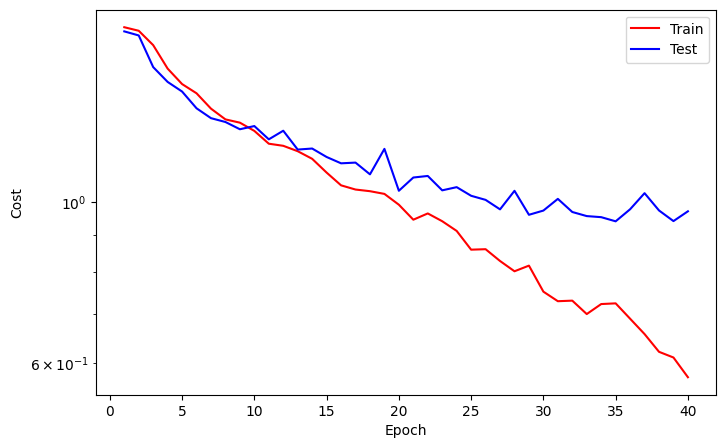

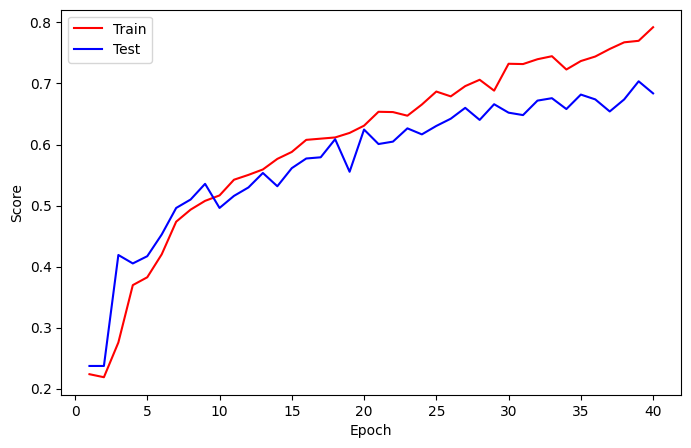

==> EarlyStop patience =  1 | Best test_score: 0.7036


Train:   0%|          | 0/16 [00:03<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    41
Train_cost  = 0.5673 | Test_cost  = 0.9446 | Train_score = 0.7887 | Test_score = 0.6957 |
==> EarlyStop patience =  2 | Best test_score: 0.7036


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    42
Train_cost  = 0.5546 | Test_cost  = 0.9720 | Train_score = 0.7932 | Test_score = 0.6838 |
==> EarlyStop patience =  3 | Best test_score: 0.7036


Train:   0%|          | 0/16 [00:12<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    43
Train_cost  = 0.5247 | Test_cost  = 1.0505 | Train_score = 0.8050 | Test_score = 0.6542 |
==> EarlyStop patience =  4 | Best test_score: 0.7036


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch    44
Train_cost  = 0.5201 | Test_cost  = 0.9667 | Train_score = 0.8125 | Test_score = 0.7115 |


Train:   0%|          | 0/16 [00:13<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    45
Train_cost  = 0.4975 | Test_cost  = 0.9956 | Train_score = 0.8130 | Test_score = 0.6996 |
==> EarlyStop patience =  1 | Best test_score: 0.7115


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch    46
Train_cost  = 0.5421 | Test_cost  = 1.2251 | Train_score = 0.8021 | Test_score = 0.6087 |
==> EarlyStop patience =  2 | Best test_score: 0.7115


Train:   0%|          | 0/16 [00:13<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch    47
Train_cost  = 0.5946 | Test_cost  = 0.9504 | Train_score = 0.7674 | Test_score = 0.6996 |
==> EarlyStop patience =  3 | Best test_score: 0.7115


Train:   0%|          | 0/16 [00:12<?, ?it/s]

Test:   0%|          | 0/4 [00:02<?, ?it/s]


Epoch    48
Train_cost  = 0.4629 | Test_cost  = 0.9819 | Train_score = 0.8298 | Test_score = 0.6957 |
==> EarlyStop patience =  4 | Best test_score: 0.7115


Train:   0%|          | 0/16 [00:02<?, ?it/s]

Test:   0%|          | 0/4 [00:03<?, ?it/s]


Epoch    49
Train_cost  = 0.4458 | Test_cost  = 1.0398 | Train_score = 0.8412 | Test_score = 0.6779 |
==> EarlyStop patience =  5 | Best test_score: 0.7115
==> Execute Early Stopping at epoch: 49 | Best test_score: 0.7115
==> Best model is saved at model


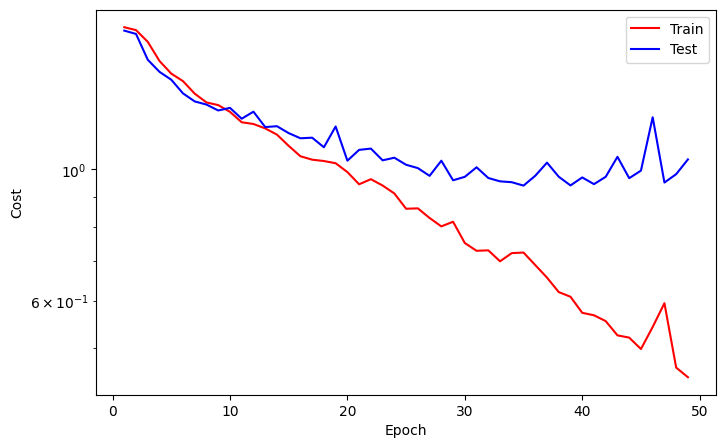

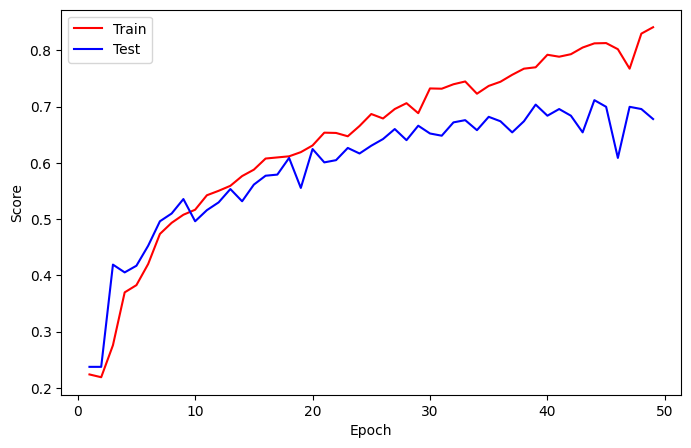

In [18]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)

    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    #Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    #Checkpoint
    callback.save_checkpoint()

    #Runtime plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    #Early stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict

In [38]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [39]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([2, 2, 2, 1, 3, 0, 0, 0, 1, 3, 1, 3, 2, 3, 4, 4, 3, 3, 4, 3, 1, 3, 0, 2,
        4, 3, 0, 3, 0, 4, 1, 3, 0, 4, 2, 1, 2, 4, 3, 3, 4, 0, 1, 0, 3, 5, 3, 1,
        3, 0, 2, 3, 1, 4, 2, 3, 3, 3, 4, 3, 2, 1, 4, 4, 3, 1, 2, 3, 3, 3, 5, 3,
        4, 3, 3, 3, 0, 4, 3, 4, 4, 0, 0, 1, 1, 4, 0, 4, 0, 5, 3, 4, 4, 2, 3, 1,
        4, 0, 0, 3, 1, 3, 0, 2, 3, 4, 5, 3, 4, 1, 3, 4, 4, 0, 3, 0, 0, 3, 5, 5,
        3, 4, 3, 4, 3, 4, 3, 3])

In [40]:
import matplotlib.pyplot as plt

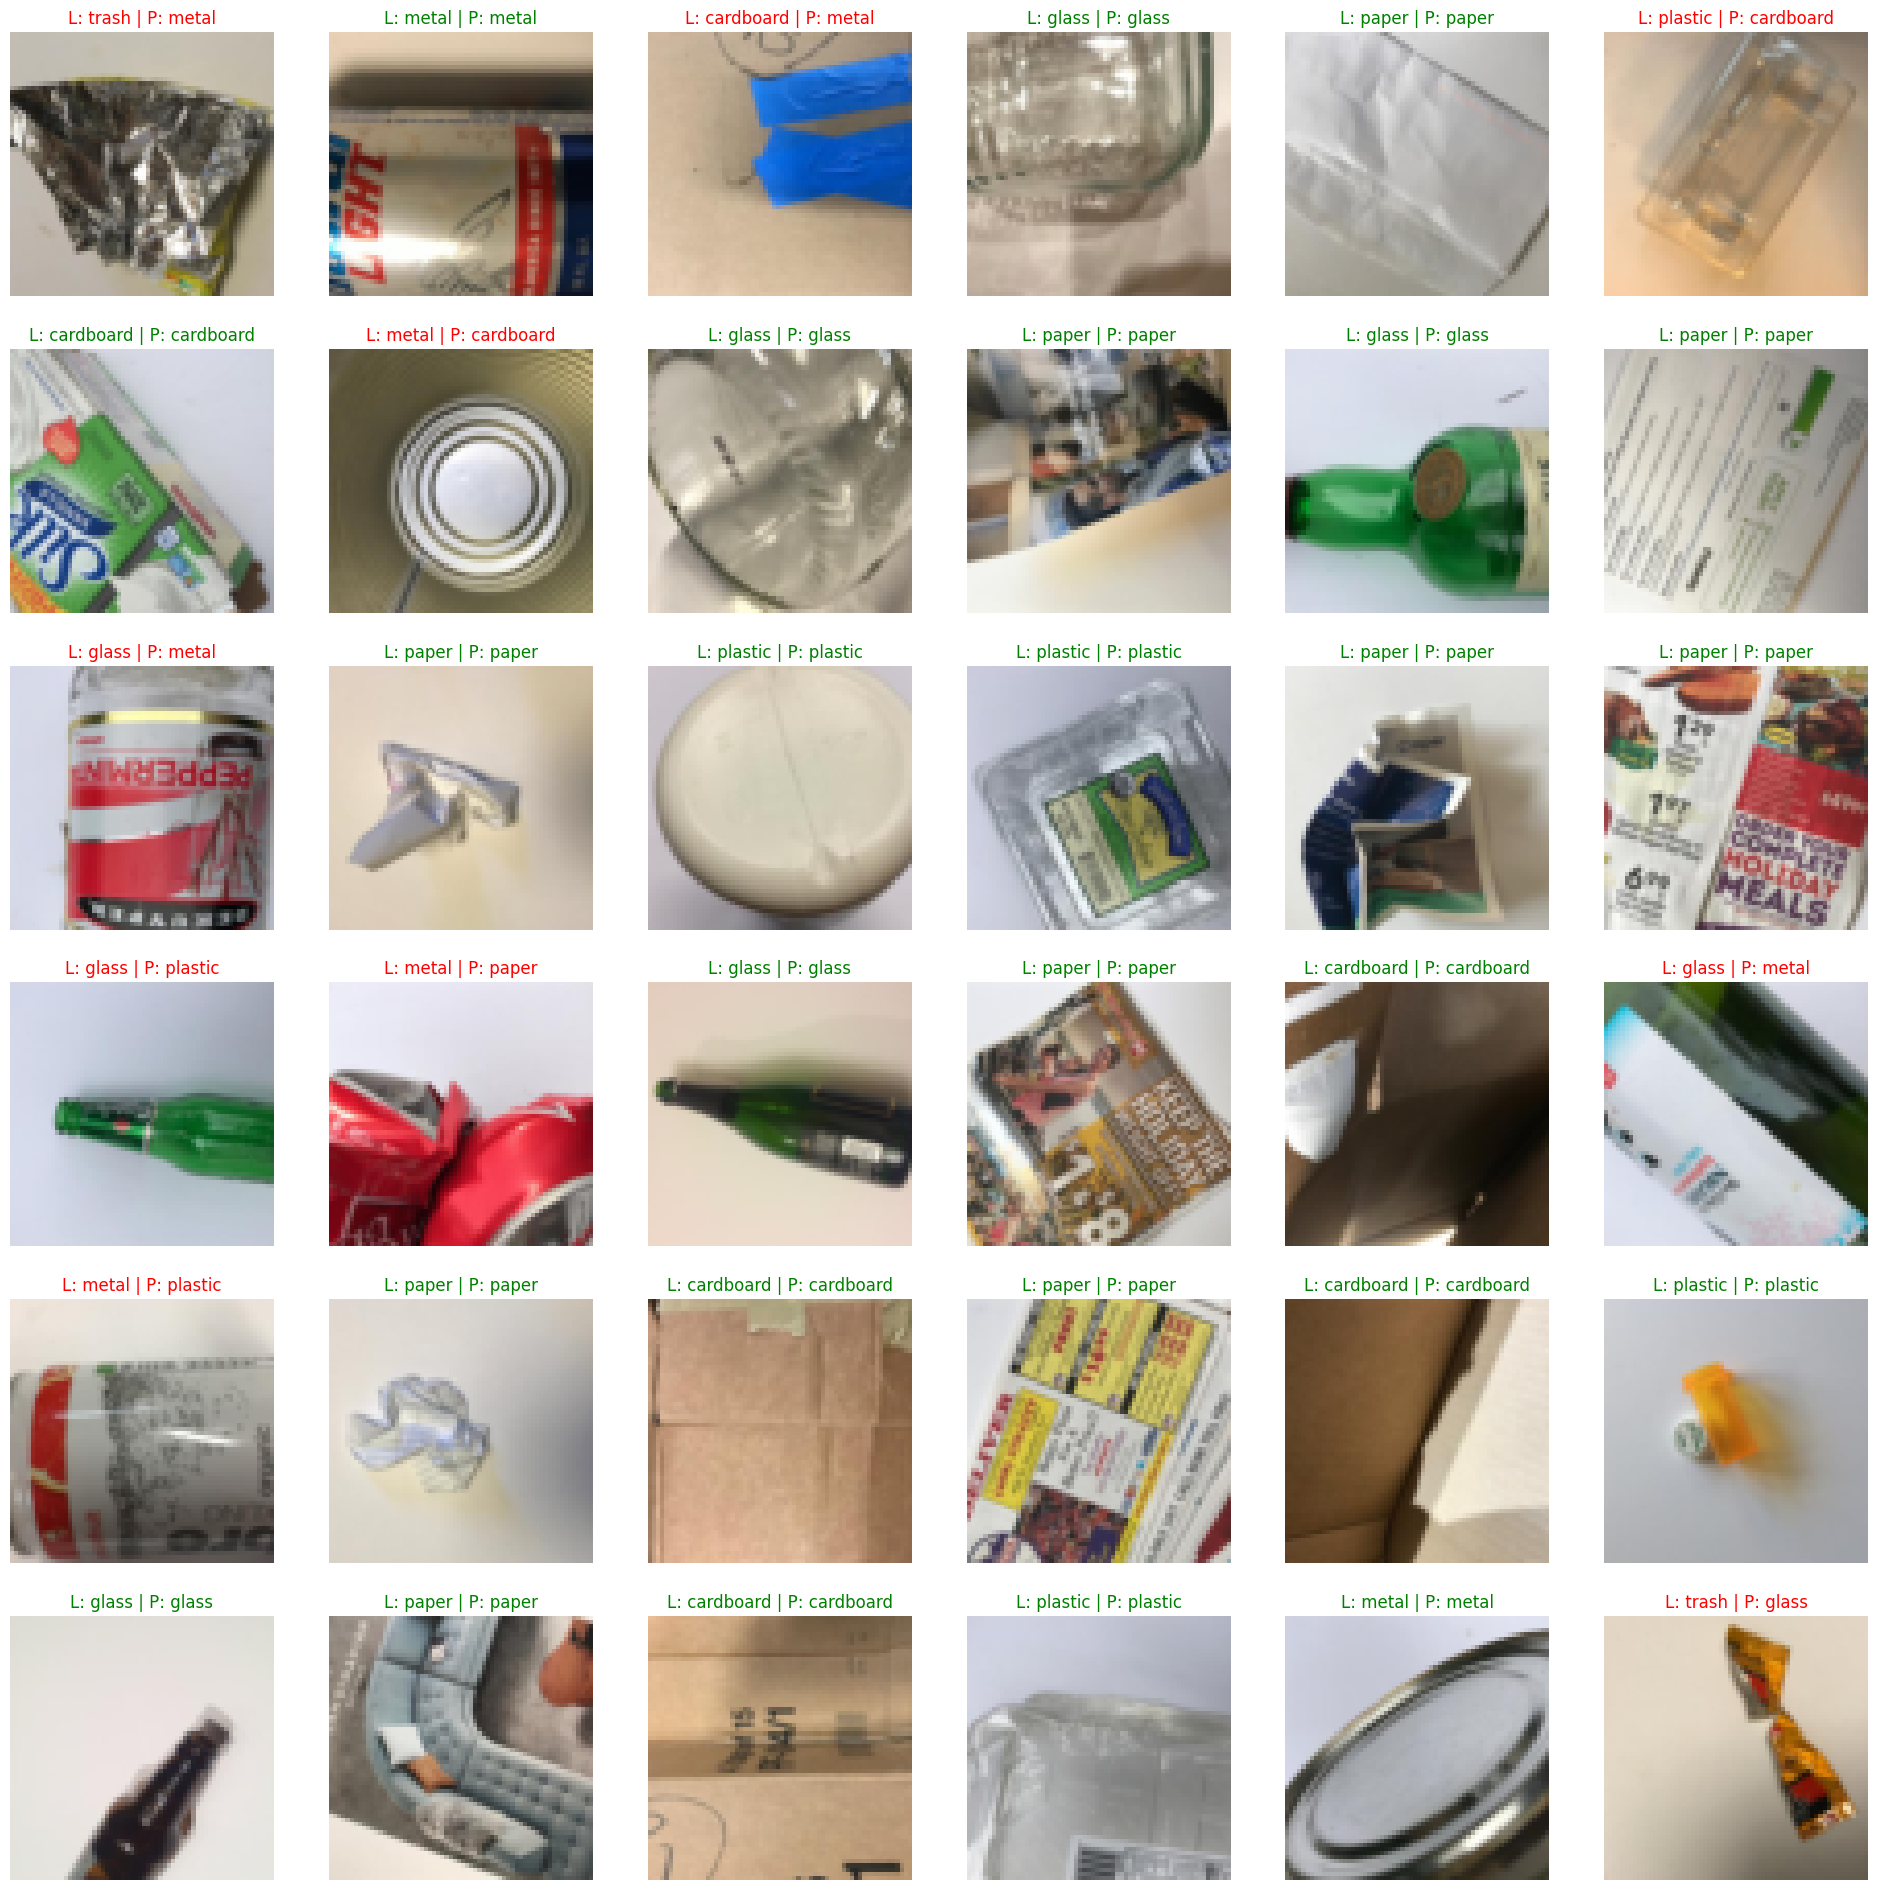

In [41]:
fig, axes = plt.subplots(6, 6, figsize = (24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color" : "r"} if label != pred else {"color" : "g"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict = font);
    ax.axis('off');

# 